In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:

# Scaling the images so that they take less space - and all have the same size
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_image_generator = ImageDataGenerator(rescale=1./255)



train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)


# Create an ImageDataGenerator for test data
test_image_generator = ImageDataGenerator(rescale=1./255)

# Use flow_from_directory to load test images
test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,  # Set batch size to 1 to process one image at a time
    class_mode=None,  # No class labels for test data
    shuffle=False  # Do not shuffle the order of images
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [6]:
import cv2


# Get a list of image file names in the test directory
test_images_filenames = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]

# Load each image using OpenCV and resize it to the desired dimensions
test_images = []
for filename in test_images_filenames:
    img_path = os.path.join(test_dir, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, convert to RGB
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    test_images.append(img)

# Convert the list of images to a numpy array
test_images = np.array(test_images)

# Normalize the images
test_images = test_images / 255.0

# Print the shape of the test images array
print("Shape of test images array:", test_images.shape)

test_data_gen = test_images

Shape of test images array: (50, 150, 150, 3)


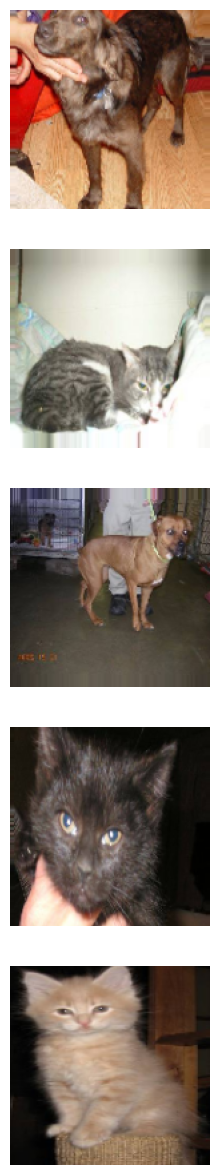

In [8]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [9]:

# Define the transformations - we do this to extend our dataset
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,      # Random rotation in the range of 0-40 degrees
    width_shift_range=0.2,   # Randomly shift width by 20%
    height_shift_range=0.2,  # Randomly shift height by 20%
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True     # Randomly flip horizontally
)



Found 2000 images belonging to 2 classes.


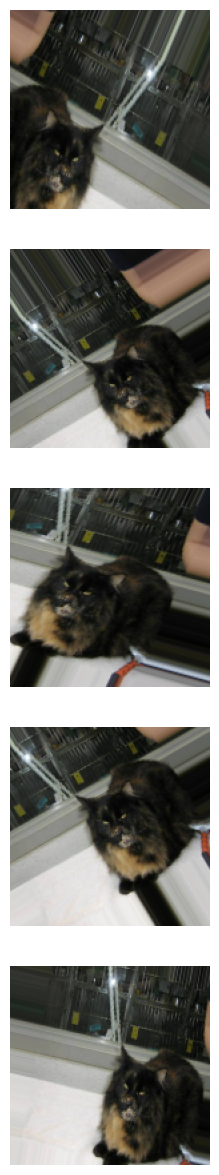

In [10]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [11]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

# Add a Conv2D layer with ReLU activation and MaxPooling2D
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Add another Conv2D layer with ReLU activation and MaxPooling2D
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Add another Conv2D layer with ReLU activation and MaxPooling2D
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

# Flatten the output from the previous layer
model.add(Flatten())

# Add a fully connected layer with ReLU activation and dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Add the output layer with softmax activation for class probabilities
model.add(Dense(2, activation='softmax'))  # Assuming binary classification (2 classes)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=2000 // batch_size,
        epochs=50,
        validation_data=val_data_gen,
        validation_steps=800 // batch_size)


model.save_weights('first_try.h5')

<ipython-input-12-ec18d003478c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
15/15 [==============================] - 109s 7s/step - loss: 4.5309 - accuracy: 0.5652 - val_loss: 0.6952 - val_accuracy: 0.5664
Epoch 2/50
15/15 [==============================] - 122s 8s/step - loss: 4.2058 - accuracy: 0.5828 - val_loss: 1.0242 - val_accuracy: 0.5091
Epoch 3/50
15/15 [==============================] - 115s 8s/step - loss: 3.4191 - accuracy: 0.5999 - val_loss: 3.1119 - val_accuracy: 0.5039
Epoch 4/50
13/15 [=========================>....] - ETA: 12s - loss: 2.3416 - accuracy: 0.6355

In [ ]:

for epoch in range(40):
    history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=2000 // batch_size,
        epochs=1,  # Train for one epoch at a time
        validation_data=val_data_gen,
        validation_steps=800 // batch_size)

    if True:
        model.save(f'model_at_epoch_{epoch + 1}.keras')

<ipython-input-11-7e284103cf66>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


14/15 [===========================>..] - ETA: 6s - loss: 1.4909 - accuracy: 0.5149 

KeyboardInterrupt: ignored

In [ ]:


model = keras.models.load_model('model_at_epoch_19.keras')
predictions = model.predict(test_data_gen)

# Extract the probabilities for being a dog (class index 1)
cat_probabilities = predictions[:,1]  # Convert to percentage
dog_probabilities = predictions[:,0]


probabilities = []

for i in range(len(cat_probabilities)):
  if cat_probabilities[i] >= dog_probabilities[i]:
    probabilities.append(0)
  else:
    probabilities.append(1)

print(probabilities)

2/2 [==============================] - 1s 198ms/step
[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]


In [ ]:
# Compare to real answers
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")


Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
